<div style="text-align: right"> Brian Wiley <br/>
EN.705.601.3VL.SP20 Applied Machine Learning </div>

## Assignment 8
### Applied Machine Learning

__1. [10 pts] How many species must be there in the dataset?__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/assignment08_dataset.csv')
df.head()

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937


(Text(0.5, 0, 'f1'), Text(0, 0.5, 'f2'))

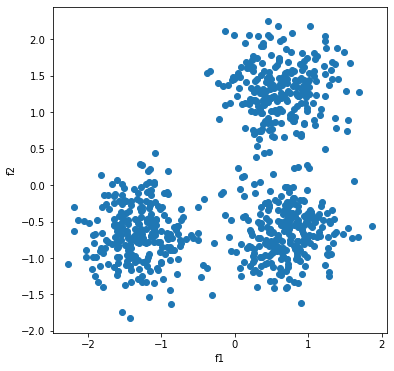

In [2]:
plt.figure(figsize=(6,6))
plt.scatter(df.f1, df.f2)
plt.xlabel("f1"), plt.ylabel("f2")

It's pretty easy to see that there are 3 clusters.  There are some points that could belong to multiple clusters which we filter out in questions 2 and 3.

__2. [10 pts] Find the rough feature ranges to classify these species correctly. It might be a good
idea to do this step visually from some data plots.__

Here I will just manually add ellipses to show the cluster regions.  In question 4 and 5 we will do this with K-means and DBSCAN.

(Text(0.5, 0, 'f1'), Text(0, 0.5, 'f2'))

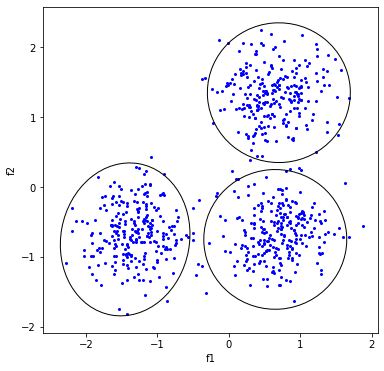

In [3]:
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
%matplotlib inline

x = df.iloc[:, 0]
y = df.iloc[:, 1]

## set ellipses
ellipse1_c = (0.70, 1.35)
ellipse1_h = 1
ellipse1_w = 2
angle1 = 5
ellipse1 = Ellipse(xy=ellipse1_c, width=ellipse1_w,
                   height=ellipse1_w, angle=angle1, fill=False)

ellipse2_c = (0.65, -0.75)
ellipse2_h = 0.9
ellipse2_w = 2
angle2 = 5
ellipse2 = Ellipse(xy=ellipse2_c, width=ellipse2_w,
                   height=ellipse2_w, angle=angle2, fill=False)

ellipse3_c = (-1.45, -0.75)
ellipse3_h = 2.2
ellipse3_w = 1.8
angle3 = -10
ellipse3 = Ellipse(xy=ellipse3_c, width=ellipse3_w,
                   height=ellipse3_h,angle=angle3, fill=False)

## add ellipses to array to add patchs with list comprehension
ellipses = [ellipse1, ellipse2, ellipse3]

## plot and add patches
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(x, y, color='b', s=4)
[ax.add_patch(i) for i in ellipses]
ax.set_xlabel("f1"), ax.set_ylabel("f2")

__3. Clean the points that are around the boundaries of the cluster (these points might be due to
errors, anomalies, or they are simply outliers). This step is done to refine feature
boundaries so that a scientist can classify the species manually, reliably, and with a high
generalization. (An example statement, "Species 1 has feature 1 in the range of [0-1.5]")__

Now I will use the function {Ellipses}.contains_point() to filter out the points that are not in the ellipses.  The trick according to the "bug" in the backend transformation to applies to screen is to transform the points according to the axes transformation.  Also since you are only allowed to add an instance of an ellipse (called a patch from the memory location) you have to recreate the patches instance to a different location in memory and the priors go to garbage collection.

We are going to plot 4 figures to show this:
1.  Original scatter plot from question 1
2.  Scatter plot with clusters from question 1 where points outside are clearly marked
3.  Removal of those points showing we only removed those outside the cluster but clusters still ellipsed
4.  Removing the ellipses to show there are clearly 3 clusters with easily defined boundaries

# Indices removed = 29
% Indices removed = 3.87%


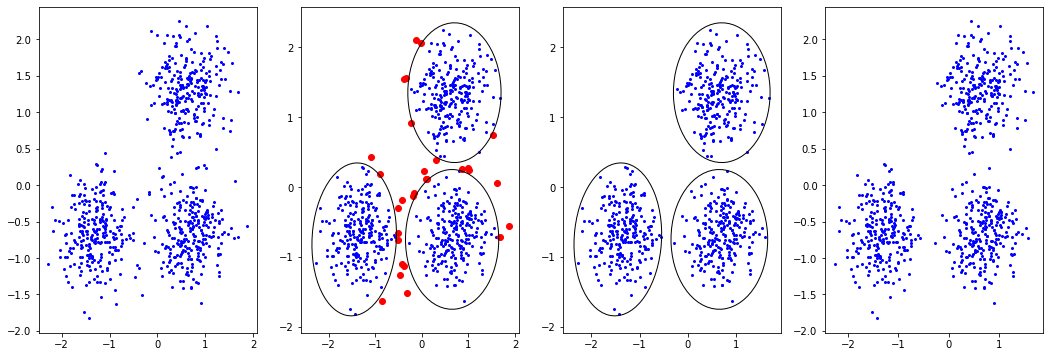

In [4]:
## ellipses function
def get_ellipses():
    ellipse1 = Ellipse(xy=ellipse1_c, width=ellipse1_w,
                       height=ellipse1_w, angle=angle1, fill=False)
    
    ellipse2 = Ellipse(xy=ellipse2_c, width=ellipse2_w,
                       height=ellipse2_w, angle=angle2, fill=False)

    ellipse3 = Ellipse(xy=ellipse3_c, width=ellipse3_w,
                       height=ellipse3_h,angle=angle3, fill=False)
    
    return [ellipse1, ellipse2, ellipse3]

## initialize figure 
fig = plt.figure(figsize=(18,6))

## Plot 1
ax0 = fig.add_subplot(141)
ax0.scatter(x, y, color='b', s=4)

## Plot 2
ax1 = fig.add_subplot(142)
ellipses = get_ellipses()
[ax1.add_patch(i) for i in ellipses]

## get indices to mark red outside of ellipse and plot
indices_to_keep = []
for idx, point in df.iterrows():
    if (ellipses[0].contains_point(ax1.transData.transform(point)) or 
        ellipses[1].contains_point(ax1.transData.transform(point)) or 
        ellipses[2].contains_point(ax1.transData.transform(point))):
        indices_to_keep.append(True)
    else:
        indices_to_keep.append(False)
len(indices_to_keep) - sum(indices_to_keep)
ax1.scatter(x[indices_to_keep], y[indices_to_keep], color='b', s=4)
ax1.scatter(x[np.invert(indices_to_keep)], 
            y[np.invert(indices_to_keep)], color='r')

## Plot 3 only indices in ellipses
ax2 = fig.add_subplot(143)
[ax2.add_patch(i) for i in get_ellipses()]
ax2.scatter(x[indices_to_keep], y[indices_to_keep], color='b', s=4)

## 4 only indices in ellipses without border
ax3 = fig.add_subplot(144)
ax3.scatter(x[indices_to_keep], y[indices_to_keep], color='b', s=4)

print("# Indices removed = {}\n" \
      "% Indices removed = {}%".format(len(df)-sum(indices_to_keep),
                                      round((len(df)-sum(indices_to_keep))/len(df)*100, 2)
                                     ))

__4. [20 pts] Use K-means clustering to find anomalies (Hint: find cluster data points that are far
to the centroid).__

I decided to try both the initial ways from the default for Kmeans for the initial point positions as well as the centers from above.  With K-mean I was able to find a way to filter out outliers but this was by distance and not by percentage.  With DBSCAN it will give a list of outliers and we can change the parameters to look for a percentage we want to dismiss.  

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score

## try init = 1) random, 2) k++, and 3) the initial ellipses centers from above

km1 = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300, 
            random_state=1,
            tol=1e-06)
y_km1 = km1.fit_predict(df)

km2 = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300, 
            random_state=1,
            tol=1e-06)
y_km2 = km2.fit_predict(df)

## get ellipse centers from questions 2 & 3 and try that also
ellipses_init = np.array([ellipse.get_center() for ellipse in ellipses])

## sanity
'''
## from K-means API 

Attributes
-----------
cluster_centers : _ndarray of shape (n_clusters, n_features)
Coordinates of cluster centers. If the algorithm stops before fully converging (see tol and max_iter), these 
will not be consistent with labels_.

Parameters
-----------
init : {'k-means++', 'random' or an ndarray}

If an ndarray is passed, it should be of shape (n_clusters, n_features)
and gives the initial centers.

'''
print(np.shape(km1.cluster_centers_) == ellipses_init.shape)

km3 = KMeans(n_clusters=3, 
            init=ellipses_init, 
            n_init=1,           ## only need 1 init when passing initial k centers
            max_iter=300, 
            random_state=1,
            tol=1e-06)
y_km3 = km3.fit_predict(df)

## print counts before plotting with subplots like in Text from Raschka
print("Counts for 'random' initial centers = {}".format(np.unique(y_km1, return_index=True, return_counts=True)))
print("Counts for 'k-mean' initial centers = {}".format(np.unique(y_km2, return_index=True, return_counts=True)))
print("Counts for manual ellipses initial centers = {}".format(np.unique(y_km3, return_index=True,  return_counts=True)))

True
Counts for 'random' initial centers = (array([0, 1, 2]), array([3, 0, 1], dtype=int64), array([250, 248, 252], dtype=int64))
Counts for 'k-mean' initial centers = (array([0, 1, 2]), array([3, 0, 1], dtype=int64), array([250, 248, 252], dtype=int64))
Counts for manual ellipses initial centers = (array([0, 1, 2]), array([0, 3, 1], dtype=int64), array([248, 250, 252], dtype=int64))


As you can see before we plot we can see that the manual centers exchanged an order for the centers but the counts are still the same amount.  My centers were top-right is center 1, bottom-right is center 2, and bottom-left is center 3 while Sklearn chose bottom-right to be center 1, top-right to be center 2, and same bottom-left is center 3.  Either way they still converged to the same centers exactly!  See below.  Also I wonder if the professor made 3 blobs of equal size 250 for this data set? :) 

In [6]:
print("Sklearn centers:\n", km2.cluster_centers_)
print("My centers:\n", km3.cluster_centers_)

Sklearn centers:
 [[ 0.6954587  -0.64442334]
 [ 0.62260555  1.3172598 ]
 [-1.30266211 -0.65704205]]
My centers:
 [[ 0.62260555  1.3172598 ]
 [ 0.6954587  -0.64442334]
 [-1.30266211 -0.65704205]]


Below function just plots the three experiments above like in text.

Text(0.5, 1.0, 'Manual Centers')

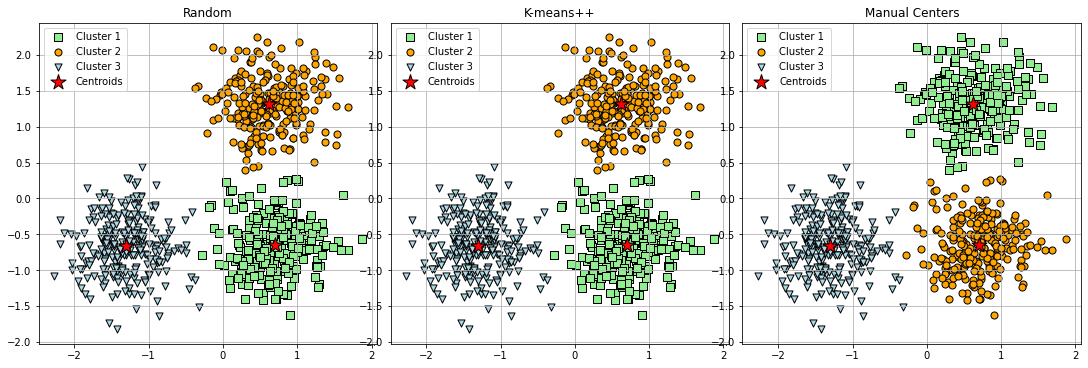

In [7]:
## plot function from Raschka
def plot_km(_km, _X, _y_km, ax=None):
    ax.scatter(_X.iloc[_y_km == 0, 0], 
               _X.iloc[_y_km == 0, 1], 
               s=50, c='lightgreen', 
               marker='s', edgecolor='black', 
               label='Cluster 1')
    ax.scatter(_X.iloc[_y_km == 1, 0], 
               _X.iloc[_y_km == 1, 1], 
               s=50, c='orange', 
               marker='o', edgecolor='black', 
               label='Cluster 2')
    ax.scatter(_X.iloc[_y_km == 2, 0], 
               _X.iloc[_y_km == 2, 1], 
               s=50, c='lightblue', 
               marker='v', edgecolor='black', 
               label='Cluster 3')
    ax.scatter(_km.cluster_centers_[:, 0], 
               _km.cluster_centers_[:, 1], 
               s=250, marker='*', 
               c='red', edgecolor='black', 
               label='Centroids')
    ax.legend(scatterpoints=1)
    ax.grid()
    #ax.tight_layout()

fig = plt.figure(figsize = (15,5), constrained_layout=True)
ax0 = fig.add_subplot(131)
plot_km(km1, df, y_km1, ax0)
ax0.set_title("Random")

ax1 = fig.add_subplot(132)
plot_km(km2, df, y_km2, ax1)
ax1.set_title("K-means++")

ax2 = fig.add_subplot(133)
plot_km(km3, df, y_km3, ax2)
ax2.set_title("Manual Centers")
                

Now lets plot some filter thresholds.  I found some resources at the links below to help:

https://datascience.stackexchange.com/questions/26206/calculate-distance-between-each-data-point-of-a-cluster-to-their-respective-clus

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_transform


Text(0.5, 1.0, 'Disance Threshold=0.8')

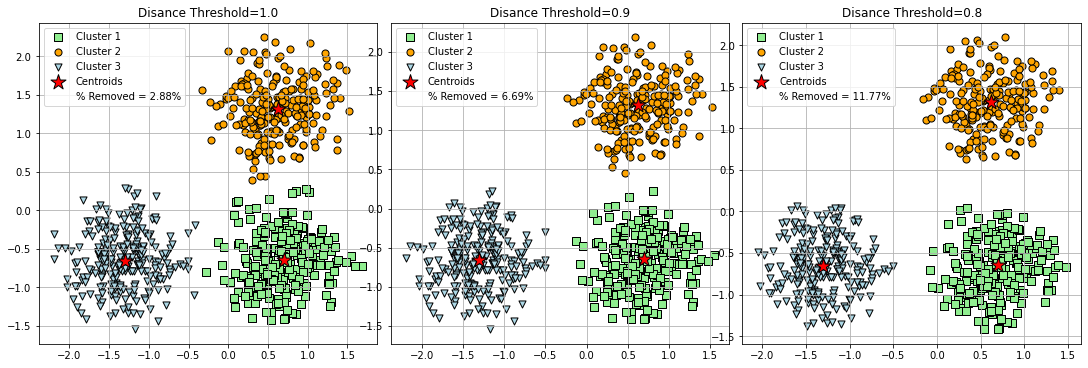

In [8]:
from matplotlib.patches import Rectangle

def plot_km_threshold(_km, _X, _y_km, dist_threshold=None, ax=None):
    
    ## this was from first link above
    idx_kept = np.min(_km.fit_transform(_X), axis=1) < dist_threshold
    percent_removed = round((len(idx_kept)-sum(idx_kept))/sum(idx_kept)*100, 2)
    
    _X_new = _X.iloc[idx_kept, :]
    _y_km_new = _y_km[idx_kept]
    
    ax.scatter(_X_new.iloc[_y_km_new == 0, 0], 
               _X_new.iloc[_y_km_new == 0, 1], 
               s=50, c='lightgreen', 
               marker='s', edgecolor='black', 
               label='Cluster 1')
    ax.scatter(_X_new.iloc[_y_km_new == 1, 0], 
               _X_new.iloc[_y_km_new == 1, 1], 
               s=50, c='orange', 
               marker='o', edgecolor='black', 
               label='Cluster 2')
    ax.scatter(_X_new.iloc[_y_km_new == 2, 0], 
               _X_new.iloc[_y_km_new == 2, 1], 
               s=50, c='lightblue', 
               marker='v', edgecolor='black', 
               label='Cluster 3')
    ax.scatter(_km.cluster_centers_[:, 0], 
               _km.cluster_centers_[:, 1], 
               s=250, marker='*', 
               c='red', edgecolor='black', 
               label='Centroids')
    extra = Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
    text = "% Removed = {}%".format(percent_removed)
    handles, labels = ax.get_legend_handles_labels()
    handles.append(extra)
    labels.append(text)
    ax.legend(handles, labels)
    ax.grid()


fig = plt.figure(figsize = (15,5), constrained_layout=True)
ax0 = fig.add_subplot(131)
plot_km_threshold(km2, df, y_km2, dist_threshold=1.0, ax=ax0)
ax0.set_title("Disance Threshold=1.0")

ax1 = fig.add_subplot(132)
plot_km_threshold(km2, df, y_km2, dist_threshold=0.9, ax=ax1)
ax1.set_title("Disance Threshold=0.9")

ax2 = fig.add_subplot(133)
plot_km_threshold(km2, df, y_km2, dist_threshold=0.8, ax=ax2)
ax2.set_title("Disance Threshold=0.8")

We will be using this cleaned set below with keeping distance threshold of within 0.85 units from the centroids for number 6 unless we can find a better way with DBSCAN to filter out 10%.

% removed = 9.81%


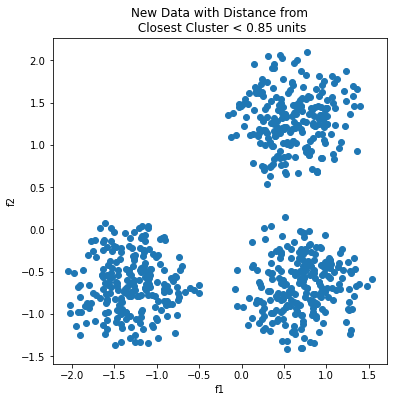

In [9]:
idx_kept = np.min(km2.fit_transform(df), axis=1) < 0.85
    
df_new = df.iloc[idx_kept, :]
x1 = df_new.iloc[:, 0]
y1 = df_new.iloc[:, 1] 

plt.figure(figsize=(6,6))
plt.scatter(x1, y1) 
plt.xlabel("f1"), plt.ylabel("f2")
plt.title("New Data with Distance from\n Closest Cluster < 0.85 units")

print("% removed = {}%".format(round((len(idx_kept)-sum(idx_kept))/sum(idx_kept)*100, 2)))

In [10]:
def kmeans_intertia_k(_n_clusters, _X):
    km = KMeans(n_clusters=_n_clusters, n_init=10, max_iter=300, random_state=0)
    km.fit(_X)
    return km.inertia_

K = 30
inertia = []

for k in range(1,K+1):
    inertia.append(kmeans_intertia_k(k, df))

Text(8, 294.0, 'inertia elbow, k = 3')

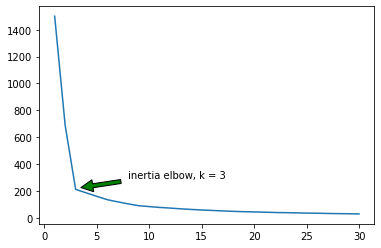

In [11]:
#plot intertia
plt.plot(np.arange(1,K+1), inertia, label='Inertia')  
plt.annotate(f"inertia elbow, k = 3", xy=(3, 220), xytext=(8, 1.4*210), arrowprops=dict(facecolor='green', shrink=.10))

__5. [20 pts] Use DBSCAN clustering to find anomalies.__


In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns

db = DBSCAN(eps=0.3, min_samples=10).fit(df)

<class 'seaborn.palettes._ColorPalette'>


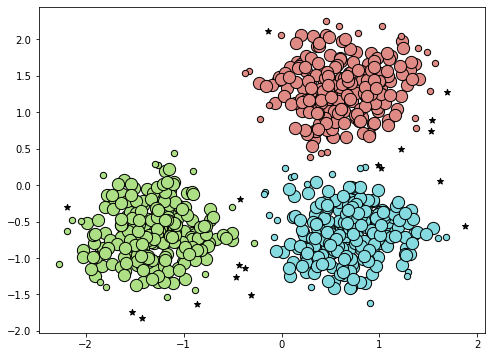

In [13]:
unique_labels = set(db.labels_)
core_samples = np.zeros_like(db.labels_, dtype=bool)
core_samples[db.core_sample_indices_] = True
unique_labels = set(db.labels_)
noise = np.where(db.labels_ == -1)


## using linspace creates colors that are very different from eachother
#colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
colors = sns.hls_palette(len(unique_labels), l=.7, s=.6)
print(type(colors))
plt.figure(figsize=(8,6))

for k, col in zip(unique_labels, colors):
    if k == -1: ### for noise make black
        col = [0, 0, 0, 1]
        marker = "*"
    else:
        marker = "o"
    
    class_members = (db.labels_ == k)
    
    X = df[class_members & core_samples]
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], marker=marker,
                color = col, edgecolor='k', s=150)
    
    X = df[class_members & ~core_samples]
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], marker=marker, color = col,
                edgecolor='k', s=40)

plt.show()

I was able to find an example to visualize how to plot outliers, (not outliers but not core samples), and core samples from the Sklearn example at the link below:

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

To prove I understand what is going on in the code in the cell above I made the visual below. When we run DBSCAN we get, well we can make, three groups of points.  We get points that not within the parameters set the first two parameters `eps` and `min_samples` and become labeled as `-1` for noise points represented by the black in the pyramid.  Then we core_samples which make up the core of the clusters (I guess that's why we name it core_samples) and are also dependent upon these two parameters.  Then we get points that are are still labeled (i.e. blue shading in the pyramid) but are not core samples. So in order to have the noise/outliers and non-core but labeled samples the same size points we reset the X in `X = df[class_members & ~core_samples]` which stands for all the labels (including noise label of -1) that are __not__ core samples.  The reason prior to that for initially setting `X = df[class_members & core_samples]` is because for when the `class_members` are the noise/outliers class, we make sure __not__ to plot the noise with larger size points using `X = df[class_members & core_samples]`  which stands for all class_members (every single points in a class member even the noise) that __are__ core samples.  The noise and the non-core samples fall into this category, it's just that we initially set the noise to a black color.  

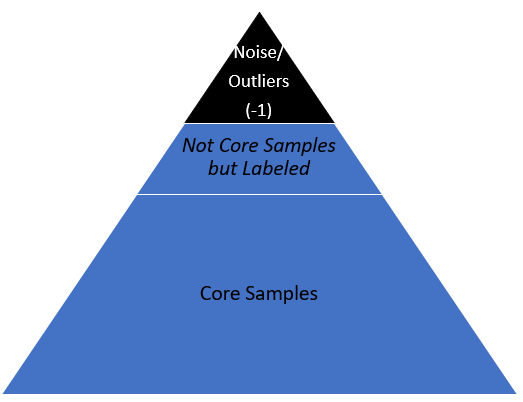

Now I will try to find the `eps` values which return a noise percentage so we filter out ~10% noise and plot the new data.  [EDIT] I notice I couldn't get close to 10% with Euclidean so I switched distance to `chebyshev` distance.


In [14]:
## let try to find the a good set of parameters to get a cutoff close to 10%
for eps in (np.arange(0.3, 0.01, -0.001)):
    db_test = DBSCAN(eps=eps, metric='chebyshev', min_samples=10).fit(df)
    noise = np.where(db_test.labels_ == -1)
    noise_percent = round(len(noise[0])/len(df), 5)
    if (np.abs(.10 - noise_percent) <= .002):
        break
print(round(eps, 3))

0.181


In [15]:
len(noise[0])

75

% removed = 10.0%


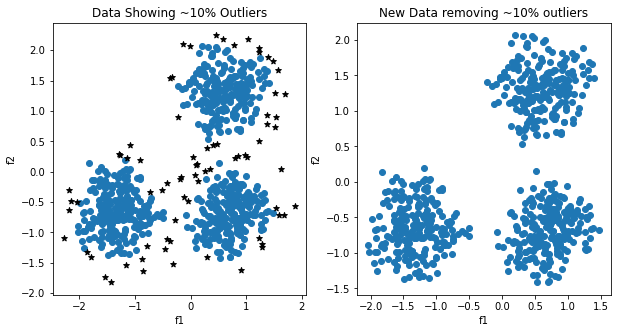

In [16]:
db_10_perc_noise = DBSCAN(eps=eps, metric='chebyshev', min_samples=10).fit(df)

good = np.where(db_10_perc_noise.labels_ != -1)[0]
bad = np.where(db_10_perc_noise.labels_ == -1)[0]
df_clean = df.iloc[good, :]

x2 = df_clean.iloc[:, 0]
y2 = df_clean.iloc[:, 1]

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax1.scatter(x2, y2)
ax1.scatter(df.iloc[bad, 0], df.iloc[bad, 1], marker="*", color='k')
ax1.set_xlabel("f1"), ax1.set_ylabel("f2")
ax1.set_title("Data Showing ~10% Outliers")

ax2 = fig.add_subplot(122)
ax2.scatter(x2, y2)
ax2.set_xlabel("f1"), ax2.set_ylabel("f2")
ax2.set_title("New Data removing ~10% outliers")

print("% removed = {}%".format(round((len(df)-len(good))/len(df)*100, 2)))

__6. [40 pts] Using the cleaned dataset, develop a decision tree classifier to model the species
and show the model decision tree__

In [17]:
## set ground truth
y_ = db_10_perc_noise.labels_[good]
print(len(y_) == len(df_clean))

True


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call

dt = DecisionTreeClassifier(random_state=0)
model = dt.fit(df_clean, y_)

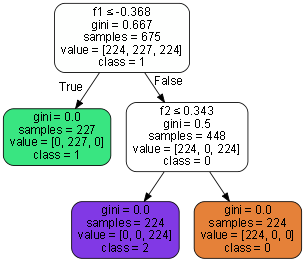

In [19]:
# export_graphviz will generate a DOT image file in the folder with this notebook
dot_data = export_graphviz(dt,
                           out_file='df_tree.dot',
                           feature_names=df_clean.columns,
                           class_names=np.array(np.unique(y_), dtype='<U10'),
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Convert the DOT file to PNG
! dot -Tpng df_tree.dot -o df_tree.png -Gdpi=60  
# Display the decision tree
Image(filename = 'df_tree.png')

__7. [20 pts bonus] Show that, in fact, it helped to clean the outliers as above, before generating
the decision tree.__

Using all data with gound truth from K-means using `K-means++` we can see that 2 of the Class 1 predictions are in different leaves.  We also see that we require an extra leaf compared to when we filter out the data as in the graph above.

In [20]:
print(len(df))
len(df) == len(y_km2)

750


True

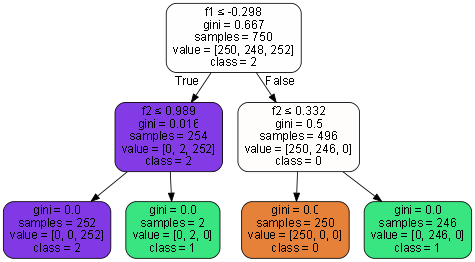

In [21]:
dt2 = DecisionTreeClassifier(random_state=0)
model2 = dt2.fit(df, y_km2)  ## use y_km2 from above with Kmeans

# export_graphviz will generate a DOT image file in the folder with this notebook
dot_data = export_graphviz(dt2,
                           out_file='df2_tree.dot',
                           feature_names=df.columns,
                           class_names=np.array(np.unique(y_km2), dtype='<U10'),
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Convert the DOT file to PNG
! dot -Tpng df2_tree.dot -o df2_tree.png -Gdpi=60  
# Display the decision tree
Image(filename = 'df2_tree.png')